In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Likelihood

To revisit at some point, and consider Bayesian methods.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(250, 250, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [4]:
with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [5]:
mask = (points.timestamps >= np.datetime64("2016-01-01")) & (points.timestamps < np.datetime64("2017-01-01"))
points = points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

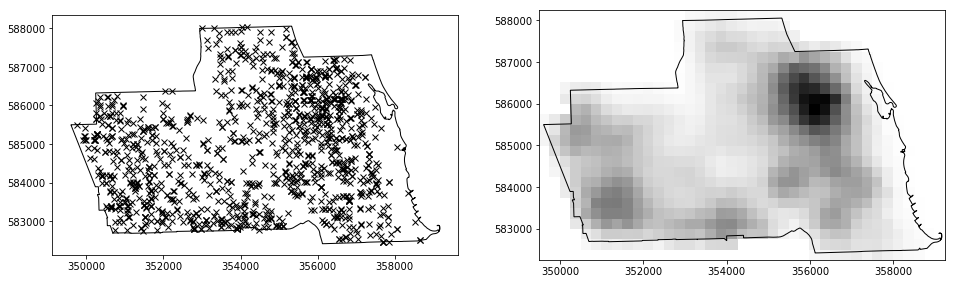

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

# Likelihood

The log likelihood is
$$ \sum_{k,i} \log\Big( \mu_k + \sum_{j<i} \theta\omega e^{-\omega(t^{(k)}_i - t^{(k)}_j)} \Big)
- \sum_k T\mu_k - \sum_{k,i} \theta(1-e^{-\omega(T-t^{(k)}_i)}) $$

If we fix $\omega$ and $\theta$ then to find the maximum value for $\mu_k$ we wish to solve
$$ \sum_i \frac{1}{\mu_k + \sum_{j<i} \theta\omega e^{-\omega(t^{(k)}_i - t^{(k)}_j)}} - T = 0. $$
This is, say,
$$ \sum_i \frac{1}{\mu+\alpha_i} = T. $$
We can numerical solve this (e.g. [Newton–Raphson](https://en.wikipedia.org/wiki/Newton%27s_method))

In [7]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)
cells = trainer.to_cells(datetime.datetime(2017,1,1))
model

ExpDecayModel(T=365.9583333333333, theta=0.024393682996555865, omega=14.470731074165611, mu size=(24, 39)

In [8]:
model.log_likelihood(cells)

-6867.611706914533

In [9]:
import scipy.optimize

def compute_alphas(pts):
    alpha = []
    for i, t in enumerate(pts):
        if i == 0:
            alpha.append(0)
            continue
        alpha.append( np.sum(model.trigger(None, t - pts[:i])) )
    return np.asarray(alpha)

def find_mu(old_mu, pts):
    if len(pts) == 0:
        return old_mu
    alpha = compute_alphas(pts)
    def func(mu):
        x = 1 / (mu + alpha)
        return np.sum(x) - model.T
    result = scipy.optimize.root(func, len(alpha) / model.T)
    mu = result.x
    assert abs(model.T - np.sum(1 / (mu+alpha))) < 1e-8
    return mu

def optimise_for_mu(model, cells):
    new_mus = [find_mu(old_mu, pts) for old_mu, pts in zip(model.mu.flat, cells.flat)]
    mu = np.asarray(new_mus).reshape(model.mu.shape)
    return model.with_mu(mu)

In [10]:
np.max(np.abs(optimise_for_mu(model, cells).mu - model.mu))

8.0213285406222079e-10

Variation as $\omega$ changes

In [11]:
x = np.linspace(0.5, 30, 100)
y = []
for omega in x:
    m = model.with_omega(omega)
    m = optimise_for_mu(m, cells)
    y.append( m.log_likelihood(cells) )

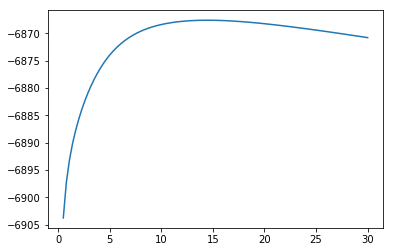

In [12]:
plt.plot(x, y)

Variation as $\theta$ changes

In [13]:
x = np.linspace(0.2, 5, 30)
y = []
for t in x:
    t = model.theta * t
    m = model.with_omega(1/7).with_theta(t)
    m = optimise_for_mu(m, cells)
    y.append( m.log_likelihood(cells) )

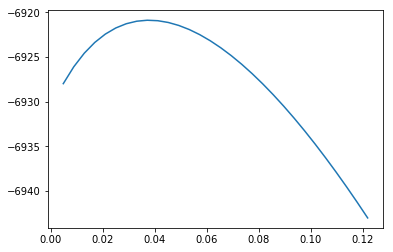

In [14]:
plt.plot(model.theta * x,y)

How does the background rate change as we force $\omega$ to different values?

In [15]:
m = model.with_omega(0.1)
m = optimise_for_mu(m, cells)

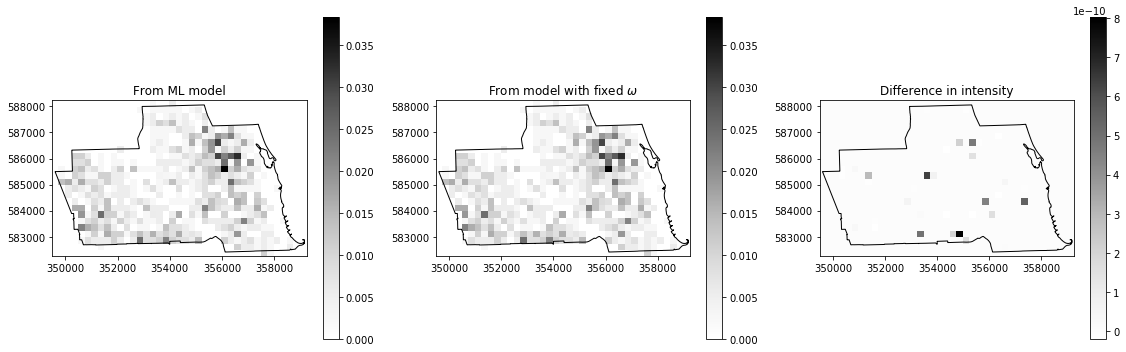

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)

ax = axes[0]
pred1 = trainer.prediction_from_background(model)
mappable = ax.pcolor(*pred1.mesh_data(), pred1.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("From ML model")

ax = axes[1]
pred2 = trainer.prediction_from_background(m)
mappable = ax.pcolor(*pred2.mesh_data(), pred2.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("From model with fixed $\omega$")

ax = axes[2]
diff = pred2.intensity_matrix - pred1.intensity_matrix
mappable = ax.pcolor(*pred1.mesh_data(), diff, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Difference in intensity")

fig.tight_layout()

What if we use a much longer time range to train with?

$\omega$ ends up a bit smaller, but not any real difference...

In [17]:
with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [18]:
mask = (points.timestamps >= np.datetime64("2010-01-01")) & (points.timestamps < np.datetime64("2017-01-01"))
points = points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

In [19]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = points
cells = trainer.to_cells(datetime.datetime(2017,1,1))
model = trainer.train(datetime.datetime(2017,1,1), iterations=100, use_fast=False)
model

ExpDecayModel(T=2556.9583333333335, theta=0.02749159321991681, omega=12.781351312146167, mu size=(24, 39)

In [20]:
model.log_likelihood(cells)

-66603.095360079154

In [21]:
m = model.with_omega(0.01)
m = optimise_for_mu(m, cells)
m.log_likelihood(cells)

-67194.97979977449

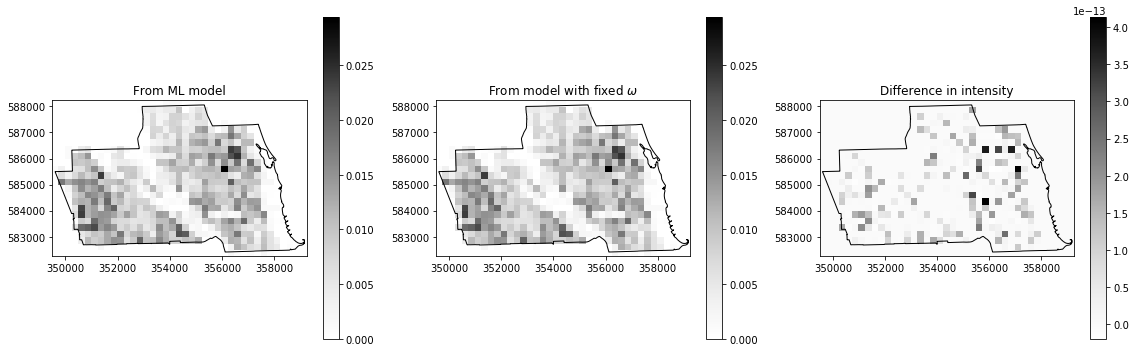

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)

ax = axes[0]
pred1 = trainer.prediction_from_background(model)
mappable = ax.pcolor(*pred1.mesh_data(), pred1.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("From ML model")

ax = axes[1]
pred2 = trainer.prediction_from_background(m)
mappable = ax.pcolor(*pred2.mesh_data(), pred2.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("From model with fixed $\omega$")

ax = axes[2]
diff = pred2.intensity_matrix - pred1.intensity_matrix
mappable = ax.pcolor(*pred1.mesh_data(), diff, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Difference in intensity")

fig.tight_layout()

So while changing $\omega$ can affect the log likelihood a lot, the background rate hardly changes!

So there is something going on here.  I'd like to look at this from a Bayesian perspective.